In [1]:
#########################################################################
#Title  : Preprocessing and Machine Learning 
#Author : Kevin Ryan Noronha

#Editors: Disha Khurana- May 29,2025- Re-trained the models using the updated distribution of data

##########################################################################

In [2]:
import sys
print(sys.executable)

/opt/anaconda3/bin/python


In [3]:
!/opt/anaconda3/bin/python -m pip install --upgrade openpyxl==3.1.2


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: /opt/anaconda3/bin/python -m pip install --upgrade pip


In [38]:
# --- 0. Imports ---
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')  # Optional: suppress common warnings

# --- 1. Load and clean the data ---
file_path = 'student_records.xlsx'
df = pd.read_excel(file_path)

# Keep only required columns
cols = ['Emplid', 'Name', 'Program Status', 'Course', 'Mark', 'Unit Value', 'Credits']
df = df[cols].drop_duplicates()

# Enforce data types
df['Emplid'] = df['Emplid'].astype(str)
df['Mark'] = pd.to_numeric(df['Mark'], errors='coerce')
df['Unit Value'] = pd.to_numeric(df['Unit Value'], errors='coerce')
df['Credits'] = pd.to_numeric(df['Credits'], errors='coerce')

# --- 2. Pivot marks into columns (one row per student) ---
pivot = df.pivot_table(
    index=['Emplid', 'Name', 'Program Status'],
    columns='Course',
    values='Mark',
    aggfunc='first'
).reset_index()

# --- 3. Compute total units and credits ---
totals = df.groupby(['Emplid', 'Name'])[['Unit Value', 'Credits']].sum().reset_index()
totals.columns = ['Emplid', 'Name', 'TotalUnits', 'TotalCredits']
totals['Emplid'] = totals['Emplid'].astype(str)

# --- 4. Merge totals with pivoted data ---
data = pivot.merge(totals, on=['Emplid', 'Name'])

# --- 5. Reorder columns ---
core_cols = ['Emplid', 'Name', 'Program Status', 'TotalUnits', 'TotalCredits']
subject_cols = [col for col in data.columns if col not in core_cols]
data = data[core_cols + subject_cols]

# --- 6. Optional: Fill missing marks with row-wise student average ---
data[subject_cols] = data[subject_cols].apply(lambda row: row.fillna(row.mean()), axis=1)

# --- 7. Optional: Drop students with too many missing course marks ---
data = data.dropna(thresh=len(data.columns) - 5)

In [24]:
# --- 1. Identify subject columns ---
subject_cols = [
    col for col in data.columns
    if col not in ['Emplid', 'Name', 'Program Status', 'TotalUnits', 'TotalCredits']
]

# --- 2. Compute GPA from average mark (scaled to 4.0 scale) ---
data['GPA'] = data[subject_cols].mean(axis=1, skipna=True) / 25

# --- 3. Cap GPA at 4.0 ---
data['GPA'] = data['GPA'].clip(upper=4.0)


In [26]:
print(data.head())

  Emplid       Name Program Status  TotalUnits  TotalCredits   COMM2301  \
0   1001  Student 1        Pending         144           120  68.125000   
1   1002  Student 2      Completed         144           144  70.250000   
2   1003  Student 3        Pending         144           132  57.000000   
3   1004  Student 4      Completed         144           144  61.000000   
4   1005  Student 5        Pending         144            96  60.333333   

    COMM2583   COMM2585  COMM2587  COMM2589   COMM2591   COMM2595  COMM2598  \
0  98.000000  68.125000      70.0      66.0  54.000000  79.000000    68.125   
1  70.250000  80.000000      62.0      66.0  62.000000  82.000000    87.000   
2  77.000000  64.444444      90.0      58.0  64.444444  64.444444    70.000   
3  78.000000  68.625000      96.0      59.0  93.000000  68.625000    68.625   
4  60.333333  34.000000      88.0      52.0  77.000000  48.000000    53.000   

    COMM2745   COMM2747   COMM2751  COMM2753   COMM2755  OART1013       GP

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Emplid          3000 non-null   object 
 1   Name            3000 non-null   object 
 2   Program Status  3000 non-null   object 
 3   TotalUnits      3000 non-null   int64  
 4   TotalCredits    3000 non-null   int64  
 5   COMM2301        3000 non-null   float64
 6   COMM2583        3000 non-null   float64
 7   COMM2585        3000 non-null   float64
 8   COMM2587        3000 non-null   float64
 9   COMM2589        3000 non-null   float64
 10  COMM2591        3000 non-null   float64
 11  COMM2595        3000 non-null   float64
 12  COMM2598        3000 non-null   float64
 13  COMM2745        3000 non-null   float64
 14  COMM2747        3000 non-null   float64
 15  COMM2751        3000 non-null   float64
 16  COMM2753        3000 non-null   float64
 17  COMM2755        3000 non-null   f

In [30]:
subject_cols = [
    c for c in data.columns
    if c not in ['Emplid', 'Name', 'Program Status', 'TotalUnits', 'TotalCredits', 'GPA']
]

for col in subject_cols:
    # Exclude zero and NaN for mean calculation
    nonzero = data[col].replace(0, np.nan).dropna()
    mu = nonzero.mean()

    # Replace NaNs and optionally zeroes with mean
    data[col].fillna(mu, inplace=True)
    # Optional: also treat zeros as missing
    data[col].replace(0, mu, inplace=True)

    # Normalize column
    data.loc[:, col] = (data[col] - mu) / mu


In [32]:
# Identifying subject columns
subject_cols = [
    c for c in data.columns
    if c not in ['Emplid', 'Name', 'Program Status', 'TotalUnits', 'TotalCredits', 'GPA']
]

# Feature matrix and target
X = data[subject_cols]
y = data['GPA']

# Save Emplid and Name for test set reference
X_ids = data[['Emplid', 'Name']]

# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, X_ids_train, X_ids_test = train_test_split(
    X, y, X_ids, test_size=0.3, random_state=42, shuffle=True
)

# Preview
print("Training samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])
print("Sample test IDs:")
print(X_ids_test.head())


Training samples: 2100
Test samples: 900
Sample test IDs:
     Emplid          Name
1801   2802  Student 1802
1190   2191  Student 1191
1817   2818  Student 1818
251    1252   Student 252
2505   3506  Student 2506


In [34]:
data[subject_cols]

,COMM2301,COMM2583,COMM2585,COMM2587,COMM2589,COMM2591,COMM2595,COMM2598,COMM2745,COMM2747,COMM2751,COMM2753,COMM2755,OART1013
0,0.152960,0.659680,0.154439,0.187732,0.118156,-0.088345,0.326114,0.157712,0.155782,-0.221714,0.147783,0.047778,0.151603,0.182939
1,0.188924,0.189720,0.355672,0.051991,0.118156,0.046715,0.376473,0.478472,0.191834,0.184348,-0.107046,0.187200,0.187524,0.187164
2,-0.035322,0.304035,0.092069,0.527084,-0.017378,0.087984,0.081781,0.189576,-0.185651,-0.035602,0.085772,0.132276,0.089386,-0.053649
3,0.032375,0.320970,0.162912,0.628890,-0.000436,0.570073,0.151957,0.166209,0.164265,-0.086360,0.156207,0.159738,-0.104074,-0.070548
4,0.021092,0.021776,-0.423839,0.493149,-0.119028,0.299953,-0.194260,-0.099321,0.023591,0.020795,0.016507,0.149176,-0.188596,0.267435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,-0.092441,-0.091833,-0.051030,0.221667,-0.135970,0.316835,-0.099837,-0.088700,-0.090219,-0.627776,-0.096516,-0.104319,0.081873,-0.442329
2996,0.590873,0.077522,-0.034084,0.493149,-0.000436,-0.138992,0.068026,0.081239,-0.813378,-0.103279,0.617426,0.075240,0.075533,0.075207
2997,-0.170715,-0.153224,-0.169651,-0.626713,0.050389,0.046715,-0.764992,-0.014352,-0.168685,-0.052522,-0.174439,-0.171917,-0.171691,0.149141
2998,0.167768,0.096575,0.135375,0.238635,0.338399,-0.493525,0.086910,0.100357,0.000971,0.319702,0.090920,0.094252,0.094551,0.064645


## RandomForestRegressor

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest R² score: 0.9595
RMSE: 0.0518
MSE: 0.0027

Top 10 largest GPA prediction errors:
     Emplid          Name  Actual GPA  Predicted GPA  Absolute Error
1192   2193  Student 1193       2.280          2.574        0.294017
1269   2270  Student 1270       1.935          2.203        0.267789
962    1963   Student 963       2.209          2.462        0.253333
179    1180   Student 180       3.235          2.986        0.248900
2268   3269  Student 2269       1.707          1.936        0.229350
1226   2227  Student 1227       2.650          2.429        0.221294
1124   2125  Student 1125       2.965          2.751        0.213544
2738   3739  Student 2739       2.244          2.452        0.207928
2952   3953  Student 2953       1.840          2.045        0.205122
693    1694   Student 694       1.830          2.030        0.200267


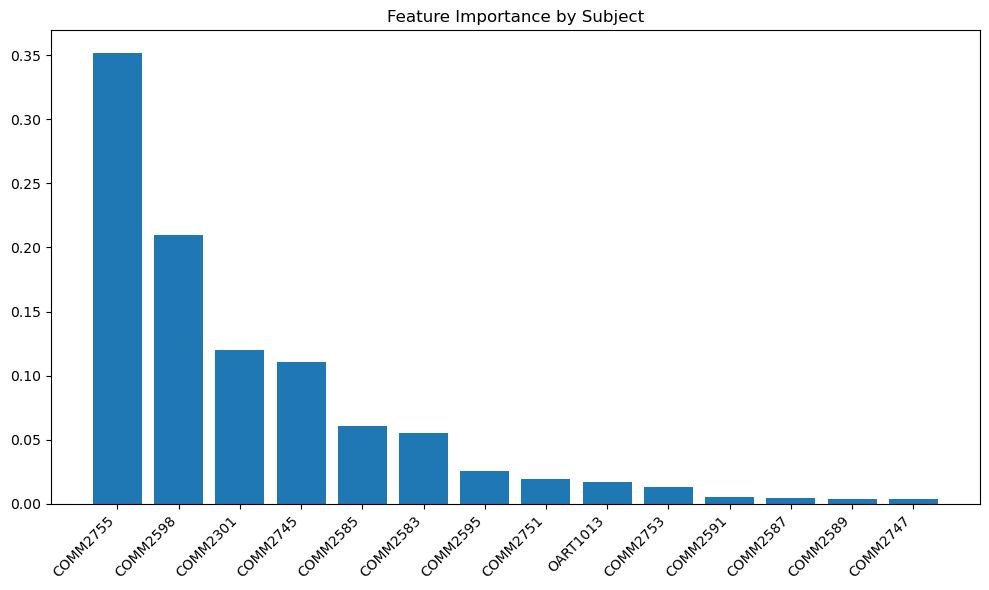

In [40]:
# Random Forest tuning (GridSearchCV)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
reg_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)

#  Predict on test set
RF_pred = reg_model.predict(X_test)

#  Evaluation
r2 = r2_score(y_test, RF_pred)
rmse = mean_squared_error(y_test, RF_pred, squared=False)
print(f"Random Forest R² score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mean_squared_error(y_test, RF_pred):.4f}")

#  Combine predictions for analysis
results_df = X_ids_test.copy()
results_df["Actual GPA"] = y_test.values
results_df["Predicted GPA"] = RF_pred
results_df["Absolute Error"] = abs(results_df["Actual GPA"] - results_df["Predicted GPA"])
results_df["Predicted GPA"] = results_df["Predicted GPA"].round(3)
results_df["Actual GPA"] = results_df["Actual GPA"].round(3)

#  Top errors
print("\nTop 10 largest GPA prediction errors:")
print(results_df.sort_values("Absolute Error", ascending=False).head(10))

#  Feature importance plot
importances = reg_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(subject_cols)), importances[indices])
plt.xticks(range(len(subject_cols)), [subject_cols[i] for i in indices], rotation=45, ha='right')
plt.title("Feature Importance by Subject")
plt.tight_layout()
plt.show()

In [42]:
# Export model + subject list
joblib.dump({
    'model': reg_model,
    'subject_cols': subject_cols
}, 'gpa_reg_model.pkl')

print("Model and metadata saved to gpa_reg_model.pkl")


Model and metadata saved to gpa_reg_model.pkl


## Gradient Boost

In [44]:
# Train model
hist_model = HistGradientBoostingRegressor(max_iter=100, random_state=42)
hist_model.fit(X_train, y_train)

# Predict
pred_HGBR = hist_model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, pred_HGBR)
rmse = mean_squared_error(y_test, pred_HGBR, squared=False)
print(f"HistGradientBoosting Regressor R² score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mean_squared_error(y_test, pred_HGBR):.4f}")

# Combine for result analysis
results_HGBR = X_ids_test.copy()
results_HGBR["Actual GPA"] = y_test.values
results_HGBR["Predicted GPA"] = pred_HGBR
results_HGBR["Absolute Error"] = abs(results_HGBR["Actual GPA"] - results_HGBR["Predicted GPA"])
results_HGBR[["Predicted GPA", "Actual GPA"]] = results_HGBR[["Predicted GPA", "Actual GPA"]].round(3)

print("\nTop 10 GPA errors (HistGradientBoosting):")
print(results_HGBR.sort_values("Absolute Error", ascending=False).head(10))


HistGradientBoosting Regressor R² score: 0.9675
RMSE: 0.0464
MSE: 0.0022

Top 10 GPA errors (HistGradientBoosting):
     Emplid          Name  Actual GPA  Predicted GPA  Absolute Error
179    1180   Student 180       3.235          3.013        0.222171
1192   2193  Student 1193       2.280          2.501        0.221274
1269   2270  Student 1270       1.935          2.150        0.214619
324    1325   Student 325       2.289          2.482        0.193342
1302   2303  Student 1303       2.169          2.358        0.189045
962    1963   Student 963       2.209          2.379        0.170570
1124   2125  Student 1125       2.965          2.794        0.170526
1261   2262  Student 1262       2.747          2.583        0.163967
564    1565   Student 565       2.147          2.308        0.161080
695    1696   Student 696       2.210          2.051        0.159399


In [46]:
# Save model and metadata
with open('gpa_hist_model_cp.pkl', 'wb') as f:
    cloudpickle.dump({
        'model': hist_model,
        'subject_cols': subject_cols
    }, f)

print("HistGradientBoosting model saved to gpa_hist_model_cp.pkl using cloudpickle.")

HistGradientBoosting model saved to gpa_hist_model_cp.pkl using cloudpickle.


## KNN Regressor

KNN Regression R² score: 0.8917
RMSE: 0.0847
MSE: 0.0072

Top 10 GPA errors (KNN):
     Emplid          Name  Actual GPA  Predicted GPA  Absolute Error
247    1248   Student 248       1.550          1.978        0.428333
543    1544   Student 544       1.889          2.200        0.310889
2012   3013  Student 2013       1.720          2.028        0.308000
208    1209   Student 209       1.695          1.999        0.304333
1134   2135  Student 1135       1.907          2.200        0.293778
2952   3953  Student 2953       1.840          2.127        0.286778
1882   2883  Student 1883       1.610          1.895        0.285222
2350   3351  Student 2351       2.044          2.323        0.278444
1204   2205  Student 1205       2.791          2.522        0.269111
1255   2256  Student 1256       1.835          2.101        0.266000


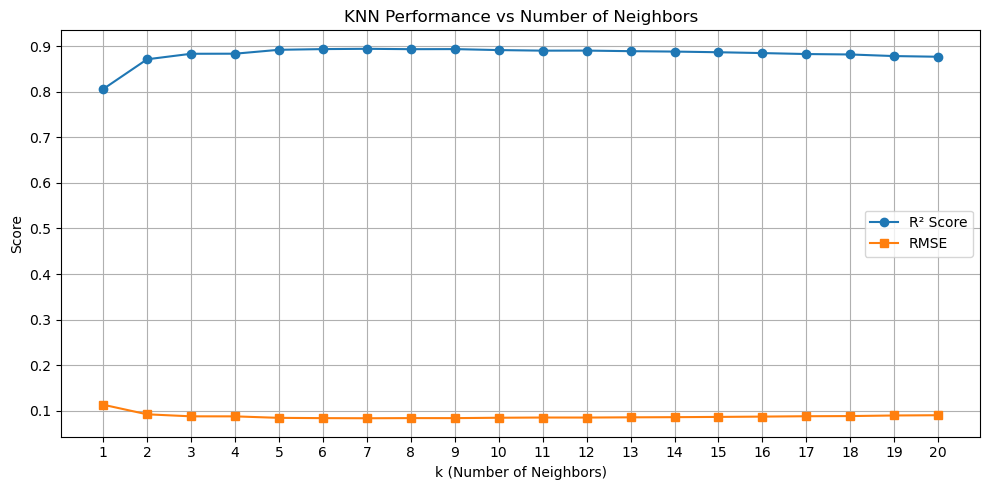

In [48]:
# --- 1. Train KNN model with default k=5 ---
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# --- 2. Predict on test data ---
pred_KNN = knn.predict(X_test)

# --- 3. Evaluate ---
r2_knn = r2_score(y_test, pred_KNN)
rmse_knn = mean_squared_error(y_test, pred_KNN, squared=False)
mse_knn = mean_squared_error(y_test, pred_KNN)

print(f"KNN Regression R² score: {r2_knn:.4f}")
print(f"RMSE: {rmse_knn:.4f}")
print(f"MSE: {mse_knn:.4f}")

# --- 4. Combine predictions for analysis ---
results_KNN = X_ids_test.copy()
results_KNN["Actual GPA"] = y_test.values
results_KNN["Predicted GPA"] = pred_KNN
results_KNN["Absolute Error"] = abs(results_KNN["Actual GPA"] - results_KNN["Predicted GPA"])
results_KNN[["Predicted GPA", "Actual GPA"]] = results_KNN[["Predicted GPA", "Actual GPA"]].round(3)

# --- 5. Display worst-case predictions ---
print("\nTop 10 GPA errors (KNN):")
print(results_KNN.sort_values("Absolute Error", ascending=False).head(10))

# --- 6. Optional: Tune k and plot R² & RMSE ---
r2_scores = []
rmse_scores = []
k_range = range(1, 21)

for k in k_range:
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    r2_scores.append(r2_score(y_test, pred))
    rmse_scores.append(mean_squared_error(y_test, pred, squared=False))

# Plot performance
plt.figure(figsize=(10, 5))
plt.plot(k_range, r2_scores, marker='o', label='R² Score')
plt.plot(k_range, rmse_scores, marker='s', label='RMSE')
plt.title('KNN Performance vs Number of Neighbors')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Score')
plt.xticks(k_range)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [50]:
joblib.dump({
    'model': knn,
    'subject_cols': subject_cols
}, 'gpa_knnreg_model.pkl')

print("Model and metadata saved to gpa_knnreg_model.pkl")

Model and metadata saved to gpa_knnreg_model.pkl
